#  Project Road Segmentation Using RandomForest Classifier


> We import the required python library for the homework below. Note that we have imported a python file(ourProjectFunctions) that contains some functions we would define ourselves. Those functions will be explained in the appropriate palces before it is to be used in the document.

In [1]:
%matplotlib inline
import matplotlib.image as mpimg
import numpy as np
import matplotlib.pyplot as plt
import os,sys
from PIL import Image

import ourProjectFunctions     # Python Function file with the functions we will use in the project. 

%load_ext autoreload

%autoreload 2



# Import Data and  View the shape of data


Next We load the images that will be used. The images have been seperated into test and training set. We first work with the trainging set to train our models.

We note that we have loaded 100 images. From this we generate our trainign-validation set. From these sets too we will do some cross validation. 

We have imported the Satellite images as imgs and ground truth as gt_images.

In [2]:
# Loaded a set of images
root_dir = "training/"

image_dir = root_dir + "images/"
files = os.listdir(image_dir)
n = min(100, len(files)) # Load  100 images. 
print("Loading " + str(n) + " images")
imgs = [ourProjectFunctions.load_image(image_dir + files[i]) for i in range(n)]
print(files[0])

gt_dir = root_dir + "groundtruth/"
print("Loading " + str(len(files)) + " images")
gt_imgs = [ourProjectFunctions.load_image(gt_dir + files[i]) for i in range(n)]
print(files[0])


Loading 100 images
satImage_001.png
Loading 100 images
satImage_001.png


Lets visualize the shape of image 0. And addition look at the length of our image. 
Note that the image set is stored in a list so that we can use the len method of list. Each element in the list is an array.

the length of the whole image is:  100
shape of image 0 is : (400, 400, 3)


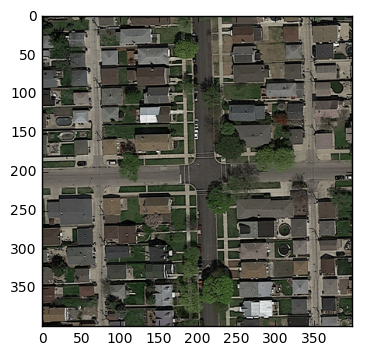

In [3]:
print("the length of the whole image is:  " + str( len(imgs)))
print("shape of image 0 is : "  + str( imgs[0].shape)  ) 

plt.imshow(imgs[0],cmap='Greys_r')

We can thus verify the total images we have loaded and also the size of each.

We can also see the contrast between the ground truth images and satellite images. Below the ground truth and the satellite images have been placed side by side to show some visual effect.

From the image below we can see what the image and its ground truth should look like.

Image size = 400,400


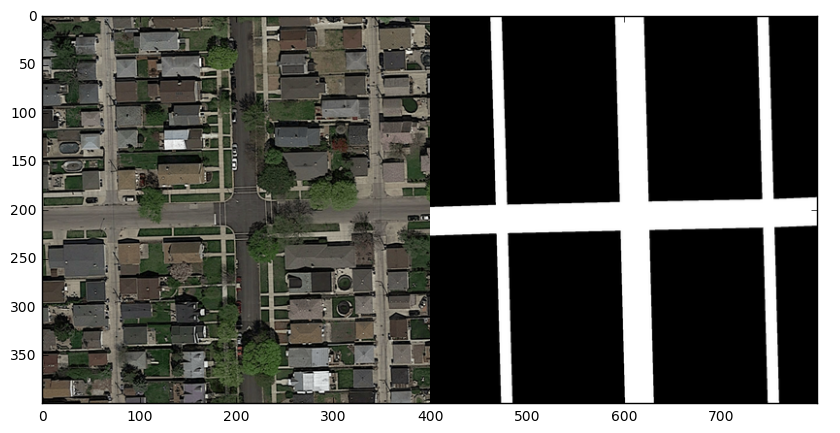

In [4]:
print('Image size = ' + str(imgs[0].shape[0]) + ',' + str(imgs[0].shape[1]))

# Show first image and its groundtruth image
cimg = ourProjectFunctions.concatenate_images(imgs[0], gt_imgs[0])
fig1 = plt.figure(figsize=(10, 10))
plt.imshow(cimg, cmap='Greys_r')

# IMAGE PATCHES EXTRACTION 

Image patching provides the ability to select arbitrary shaped regions on an image.

For better feature processing/extraction(edges, lines etc) and image processing analysis it is imperative we extract patches from the images. It is from these patches that will help define what our features set and training set would be.

In [5]:
# Extract patches from input images
patch_size = 16 # each patch is 16*16 pixels

img_patches = [ourProjectFunctions.img_crop(imgs[i], patch_size, patch_size) for i in range(n)]
gt_patches = [ourProjectFunctions.img_crop(gt_imgs[i], patch_size, patch_size) for i in range(n)]
# Linearize list of patches
img_patches = np.asarray([img_patches[i][j] for i in range(len(img_patches)) for j in range(len(img_patches[i]))])
gt_patches =  np.asarray([gt_patches[i][j] for i in range(len(gt_patches)) for j in range(len(gt_patches[i]))])
print ("lenth and shape of Satellite  images after patching and  Linearisatio: ")
print(len(img_patches))
print(img_patches.shape)
print ("lenth and shape of Ground truth  images after patching and Linearisation: ")
print(len(gt_patches))
print(gt_patches.shape)

lenth and shape of Satellite  images after patching and  Linearisatio: 
62500
(62500, 16, 16, 3)
lenth and shape of Ground truth  images after patching and Linearisation: 
62500
(62500, 16, 16)


The difference in shape returned observed is because Satellite images are 3d while ground truth are gray level images.

# Feature Sets  and  Targets Generation

> Here we generate out Feature sets which we give the variable name X and targets Y. This we will generate from the img_patches and gt_patches we have separated above.

In [7]:
X = np.asarray([ ourProjectFunctions.extract_features_2d(img_patches[i]) for i in range(len(img_patches))])
Y = np.asarray([ourProjectFunctions.value_to_class(np.mean(gt_patches[i])) for i in range(len(gt_patches))])

In [8]:
# Print feature statistics

print('Computed ' + str(X.shape[0]) + ' features')
print('Feature dimension = ' + str(X.shape[1]))
print('Number of classes = ' + str(np.max(Y)))

Y0 = [i for i, j in enumerate(Y) if j == 0]
Y1 = [i for i, j in enumerate(Y) if j == 1]
print('Class 0: ' + str(len(Y0)) + ' samples')
print('Class 1: ' + str(len(Y1)) + ' samples')

Computed 62500 features
Feature dimension = 2
Number of classes = 1
Class 0: 46309 samples
Class 1: 16191 samples


To get a good model we should divide train/feature sets each into training and validation set. To do this we use the sklearn library .

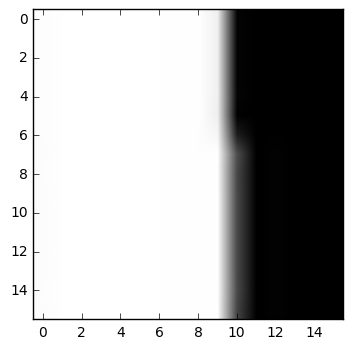

In [7]:
# Display a patch for Y0
plt.imshow(gt_patches[Y1[8]], cmap='Greys_r')

In [10]:
from sklearn.cross_validation import train_test_split

X_train, X_test, y_train, y_test = train_test_split(X,Y,train_size=0.80, random_state=4)


# Neural Classifer Neural 

> We import sklearn Neural  classifier and train a model on it. 

In [51]:
from sknn.mlp import Classifier, Layer

neuralSoftMaxClassifier = Classifier(
    layers=[
        
        Layer("Softmax")],
    learning_rate=0.1,
    n_iter=25)
neuralSoftMaxClassifier.fit(X_train, y_train)

Classifier(batch_size=1, callback=None, debug=False, dropout_rate=None,
      f_stable=0.001,
      layers=[<sknn.nn.Layer `Softmax`: frozen=False, name='output', units=2>],
      learning_momentum=0.9, learning_rate=0.1, learning_rule='sgd',
      loss_type=None, n_iter=25, n_stable=10, normalize=None,
      output=<sknn.nn.Layer `Softmax`: frozen=False, name='output', units=2>,
      parameters=None, random_state=None, regularize=None, valid_set=None,
      valid_size=0.0, verbose=None, warning=None, weight_decay=None)

Lets use different parameter for our classifier and observe the change . we name the new  classifier neuralclassifier

In [41]:
neuralClassifier = Classifier(
    layers=[
        Layer("Rectifier", units=100),
        Layer("Softmax")],
    learning_rate=0.02,
    n_iter=10)
neuralClassifier.fit(X_train, y_train)

Classifier(batch_size=1, callback=None, debug=False, dropout_rate=None,
      f_stable=0.001,
      hidden0=<sknn.nn.Layer `Rectifier`: frozen=False, name='hidden0', units=100>,
      layers=[<sknn.nn.Layer `Rectifier`: frozen=False, name='hidden0', units=100>, <sknn.nn.Layer `Softmax`: frozen=False, name='output', units=2>],
      learning_momentum=0.9, learning_rate=0.02, learning_rule='sgd',
      loss_type=None, n_iter=10, n_stable=10, normalize=None,
      output=<sknn.nn.Layer `Softmax`: frozen=False, name='output', units=2>,
      parameters=None, random_state=None, regularize=None, valid_set=None,
      valid_size=0.0, verbose=None, warning=None, weight_decay=None)

# Prediction and Accuracy Score

Having trained our model lets see how well it is doing. Note that we now use the X_test to predict new target variable y_pred. We will compare this with the y_test.

We also train the model on X_train and the results of that willl be compared with y_train for accuracy


In [46]:
y_pred= neuralClassifier.predict(X_test)
pred_train= neuralClassifier.predict(X_train)


In [47]:
import sklearn as sk
from sklearn.metrics import accuracy_score

print("accuracy score for test set: "+ str( sk.metrics.accuracy_score(y_test, y_pred , normalize=True)) )
print("Accuracy score for training set: " + str( sk.metrics.accuracy_score(y_train, pred_train,normalize=True)) )

accuracy score for test set: 0.74912
Accuracy score for training set: 0.74608


The score reported above is not different from that we obtained from RandomForestClassifier.



In [49]:
from sklearn.metrics import confusion_matrix
confusion_matrix = confusion_matrix(y_test, y_pred)
confusion_matrix

array([[9091,  209],
       [2927,  273]])

To interterprete the matrix above: The diagonal elements show the number of correct classifications for each class. The off-diagonal elements provides the misclassifications. In particular note that we have the target labels 
as [0,1 ]. Making these labels the header and index of the above matrix and we can read out how the diagonals represent the correct classification and misclassification. For example in Row 2 column 1, 314 will represent those values that are class 1 but misclassified as 0. 

Lastly we give the r2_score of our model. r2_score computes the coefficient of determination (https://en.wikipedia.org/wiki/Coefficient_of_determinationprovides ). It is a measure of how well future samples are likely to be predicted by the model. We obtained a value of 0.56 (1 being the best). We model r2_score can be increased by changing the parameters.

In [50]:
from sklearn.metrics import r2_score


print("r2 score for test set: "+ str( sk.metrics.r2_score(y_test, y_pred)) )


r2 score for test set: -0.317204301075


Lets use "Neural classifer and observe the accuracy"

In [70]:
y_pred= neuralClassifier.predict(X_test)
pred_train= neuralClassifier.predict(X_train)
print("accuracy score for test set: "+ str( sk.metrics.accuracy_score(y_test, y_pred , normalize=True)) )
print("Accuracy score for training set: " + str( sk.metrics.accuracy_score(y_train, pred_train,normalize=True)) )

accuracy score for test set: 0.74912
Accuracy score for training set: 0.74608


# Cross Validation To Mitigate Overfitting And Parameter Tuning


We perform cross validation on our model. The model still reports mean cross validation score.

In [67]:
from sklearn.cross_validation import cross_val_score

cross = (cross_val_score(ForestClassifier, X_train, y_train, cv=10))
np.mean(cross)

0.75292007000640282

In [69]:
from sklearn.grid_search import GridSearchCV
from scipy import stats
from sklearn.grid_search import RandomizedSearchCV

randomNeuralNet = RandomizedSearchCV(neuralClassifier, param_distributions={
    'learning_rate': [0.05, 0.01, 0.005, 0.001],
    'learning_momentum': [0.9,0.8,0.6],    
    'regularize': ['L1','L2'],
    'learning_rule': ['sgd', 'momentum', 'nesterov', 'adadelta', 'adagrad', 'rmsprop']})
randomNeuralNet.fit(X_train, y_train)

RandomizedSearchCV(cv=None, error_score='raise',
          estimator=Classifier(batch_size=1, callback=None, debug=False, dropout_rate=None,
      f_stable=0.001,
      hidden0=<sknn.nn.Layer `Rectifier`: frozen=False, name='hidden0', units=100>,
      layers=[<sknn.nn.Layer `Rectifier`: frozen=False, name='hidden0', units=100>, <sknn.nn.Layer `Softmax`: fr...egularize=None, valid_set=None,
      valid_size=0.0, verbose=None, warning=None, weight_decay=None),
          fit_params={}, iid=True, n_iter=10, n_jobs=1,
          param_distributions={'learning_rule': ['sgd', 'momentum', 'nesterov', 'adadelta', 'adagrad', 'rmsprop'], 'regularize': ['L1', 'L2'], 'learning_rate': [0.05, 0.01, 0.005, 0.001], 'learning_momentum': [0.9, 0.8, 0.6]},
          pre_dispatch='2*n_jobs', random_state=None, refit=True,
          scoring=None, verbose=0)

Accuracy of our model after randomized search for parameters

In [71]:
y_pred= randomNeuralNet.predict(X_test)
pred_train= randomNeuralNet.predict(X_train)
print("accuracy score for test set: "+ str( sk.metrics.accuracy_score(y_test, y_pred , normalize=True)) )
print("Accuracy score for training set: " + str( sk.metrics.accuracy_score(y_train, pred_train,normalize=True)) )

accuracy score for test set: 0.75464
Accuracy score for training set: 0.74892
